In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 显示所有行
pd.set_option('display.max_rows', None)

In [3]:
# df_hs = pd.read_excel("data/上市公司沪市.xls",converters= {u'StockCode':str})
# df_ss = pd.read_excel("data/上市公司深市.xls",converters= {u'StockCode':str})
# df_zxb = pd.read_excel("data/上市公司中小板.xls",converters= {u'StockCode':str})
# df_cyb = pd.read_excel("data/上市公司创业板.xls",converters= {u'StockCode':str})

df_hsA = pd.read_excel("data/沪深A股.xls",converters= {u'StockCode':str})

df_sz50 = pd.read_excel("data/上证50.xls",converters= {u'StockCode':str})
df_hs300 = pd.read_excel("data/沪深300.xls",converters= {u'StockCode':str})
df_zz500 = pd.read_excel("data/中证500.xls",converters= {u'StockCode':str})

In [4]:
# df = pd.concat([df_hs,df_ss])
df = df_hsA

In [5]:
# df.head(3)

In [6]:
def disposePrice(price):
    if price == '-':
        return 0
    else:
        return float(price)
# 获取行业大类
def getTopTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        return trades[0].strip()
# 获取行业小类
def getSubTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        if len(trades) > 1:
            return trades[1].strip()
        else:
            return ''
# 处理PB数据
def disposePB(pb):
    if (pb == '--') | (pb == '-NF') | (pb == '未公布'):
        return 0
    else:
        return float(pb)
def disposePE(pe):
    if (pe == '--') | (pe == '亏损') | (pe == '未公布'):
        return 0
    else:
        return float(pe)
    
def disposeEarningsPerShare(eps):
    if eps == '未公布':
        return 0
    else:
        index = eps.find('元')
        return float(eps[:index])

def getNetProfit(np_des):
    if np_des == '未公布':
        return 0
    else:
        np_des = np_des.strip()
        index_np = np_des.find('亿元')

        return float(np_des[:index_np])

def getNetProfitRate(np_des):
    np_des = np_des.strip()
    index_rate_s = np_des.find('增长')
    index_rate_e = np_des.find('%')
    
    if index_rate_s != -1:
        return float(np_des[index_rate_s+2:index_rate_e])
    else:
        return 0
    
def disposeNetProfitRate(netProfitRate):
    if netProfitRate == 0:
        return -1
    else:
        return netProfitRate

def disposeROE(roe):
    if roe == '未公布':
        return 0
    else:
        return float(roe.replace('%',''))

def disposeGrossProfitRate(gpr):
    if gpr == '未公布':
        return 0
    else:
        index = gpr.find('%')
        return float(gpr[:index])
    
#每股净资产    
def disposeNetAssetValuePerShare(navps):
    if navps == '未公布':
        return 0
    else:
        index = navps.find('元')
        return float(navps[:index])

def disposeCapitalStock(cs):
    if cs == '未公布':
        return 0
    else:
        index = cs.find('亿股')
        return float(cs[:index])

def disposeScaleShareType(sst):
    return sst.strip()

In [7]:
df['Price'] = df['Price'].apply(lambda x:disposePrice(x))

df['PB'] = df['PB'].apply(lambda x:disposePB(x))

df['PE_S'] = df['PE_S'].apply(lambda x:disposePE(x))

df['PE_D'] = df['PE_D'].apply(lambda x:disposePE(x))

df['EarningsPerShare'] = df['EarningsPerShare'].apply(lambda x:disposeEarningsPerShare(x))

df['NetProfit'] = df['NetProfitDes'].apply(lambda x:getNetProfit(x))

df['NetProfitRate'] = df['NetProfitDes'].apply(lambda x:getNetProfitRate(x))

df['GrossProfitRate'] = df['GrossProfitRate'].apply(lambda x:disposeGrossProfitRate(x))

df['NetAssetValuePerShare'] = df['NetAssetValuePerShare'].apply(lambda x:disposeNetAssetValuePerShare(x))

df['CapitalStock'] = df['CapitalStock'].apply(lambda x:disposeCapitalStock(x))

df['ScaleShareType'] = df['ScaleShareType'].apply(lambda x:disposeScaleShareType(x))

df = df.drop(['NetProfitDes'],axis=1)

df['ROE'] = df['ROE'].apply(lambda x:disposeROE(x))

# 新建行业大类
df['TopTrade'] = df['Trade'].apply(lambda x:getTopTrade(x))

# 新建行业小类
df['SubTrade'] = df['Trade'].apply(lambda x:getSubTrade(x))

df = df.drop(['Trade'],axis=1)

# 新增市盈率增长率 = 市盈率（PE）/净利润增长率（NetProfitRate）
df['PEG'] = df['PE_S'] / df['NetProfitRate'].apply(lambda x:disposeNetProfitRate(x))

# 行业分布

In [31]:
s_top = df.groupby(['TopTrade'],as_index=False).size()

In [32]:
s_top = s_top.sort_values(ascending=False)

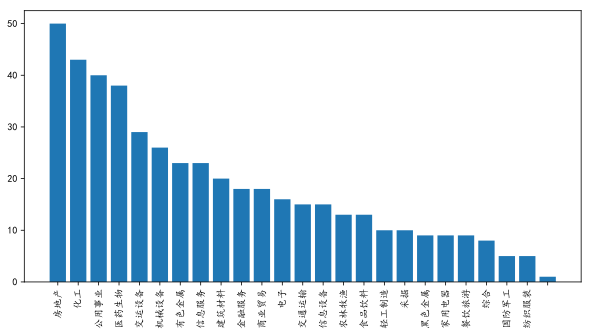

In [33]:
plt.figure(figsize=(10,5))
plt.bar(s_top.keys(),s_top.values)
plt.xticks(rotation=90)
plt.show()

# 市净率分析
## 理论上，市净率越小越好

In [58]:
df_bank = df[df['SubTrade'] == '银行']

df_bank.sort_values(by=['PB'],ascending = True)

# 市盈率增长率（PEG）
## 理论上越小越好

In [65]:
df_peg = df[df['PEG'] > 0]

df_peg[df_peg['TopTrade'] == '机械设备'].sort_values(by=['PEG'],ascending=True).head(10)

# 净资产收益率ROE÷市净率PB
## ROE应选择5%以上的为宜
## 理论上越大越好

In [74]:
df_pb = df[df['PB'] != 0]

df_pb['ROE/PB'] = df_pb['ROE'] / df_pb['PB']

df_pb[df_pb['TopTrade'] == '机械设备'].sort_values(by=['ROE/PB'],ascending=False).head(10)

In [7]:
# 根据指标获取优质股票
def getSuperiorStockByTargets(df,trade,targets,top):
    if len(targets) >= 2:
        code_list = []
        for target in targets:
            df_temp = df.copy()
            if target == 'PEG':
                df_temp = df_temp[df_temp['PEG'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'ROE/PB':
                df_temp = df_temp[df_temp['PB'] != 0]
                df_temp['ROE/PB'] = df_temp['ROE'] / df_temp['PB']
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=False).head(top)
            elif target == 'PB':
                df_temp = df_temp[df_temp['PB'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'PE_D':
                df_temp = df_temp[df_temp['PE_D'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            else:
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            
            code_list.append(list(df_temp['StockCode']))
        both = code_list[0]
        code_list.pop(0)
        while(len(code_list) > 0):
            next_list = code_list[0]
            both = [l for l in both if l in next_list]
            code_list.pop(0)
        return both
    
def getSuperiorStock(df):
    df_gpr = df.copy()
    #毛利率（高，30%~50%）
    df_gpr = df_gpr[df_gpr['GrossProfitRate'] > 30]
    
    #股本（低，小于10亿）
    df_cs = df.copy()
    df_cs = df_gpr[df_gpr['CapitalStock'] < 10]
    
    #净资产收益率（ROE）（高，大于5%）
    df_roe = df.copy()
    df_roe = df_roe[df_roe['ROE'] > 5]
    
    #小盘股
    df_sst = df.copy()
    df_sst = df_sst[df_sst['ScaleShareType'] == '小盘股']
    
    df_list = [df_gpr,df_cs,df_roe,df_sst]
    code_list = []
    for d in df_list:
        code_list.append(list(d['StockCode']))    

    both = code_list[0]
    code_list.pop(0)
    
    while(len(code_list) > 0):
        next_list = code_list[0]
        both = [l for l in both if l in next_list]
        code_list.pop(0)
    return both

In [8]:
# getSuperiorStockByTargets(df,'',['PB','PE_D'],100)

# sl = getSuperiorStock(df)

In [14]:
df_long = df[df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') >= 0) & (df['PE_D'] > 0) & (df['PE_D'] < 15)]

In [15]:
df_long = df_long.sort_values(['PE_D'],ascending=True)

In [21]:
df_long.groupby(by=['TopTrade'],as_index=False).size()

NameError: name 'df_long' is not defined

In [20]:
# df[(df['FinanceAnalize'].apply(lambda x:str(x).find('绩优股') >= 0) & (df['PE_D'] < 20) & (df['GrossProfitRate'] > 30) & (df['TopTrade'] == '食品饮料') )]

In [19]:
# df[(df['SubTrade'] == '房地产开发') & df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') >= 0)]

In [12]:
df_target = df[
    df['StockCode'].apply(lambda x:x.find('3') != 0) &
    df['StockName'].apply(lambda x:x.find('*ST') != 0) &
    df['StockName'].apply(lambda x:x.find('ST') != 0) &
    df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') < 0) &
    (df['EarningsPerShare'] > 0) & 
   ((df['Price'] < 10) & (df['Price'] != 0)) & 
   (df['SubTrade'] != '银行') & 
   (df['ScaleShareType'] == '小盘股')].sort_values(by=['EarningsPerShare'],ascending=False)

In [13]:
df_target

,StockCode,StockName,Price,PB,PE_S,PE_D,EarningsPerShare,ROE,GrossProfitRate,NetAssetValuePerShare,CapitalStock,ScaleShareType,FinanceAnalize,NetProfit,NetProfitRate,TopTrade,SubTrade,PEG
3212,600287,江苏舜天,6.56,1.300,33.54,3.671,0.4500,9.16,9.23,5.06,4.37,小盘股,NaN,1.95,1120.92,商业贸易,贸易,0.029922
2431,000919,金陵药业,7.73,1.290,16.11,4.631,0.4200,7.40,22.69,6.00,5.04,小盘股,NaN,2.10,346.50,医药生物,化学制药,0.046494
1367,600995,文山电力,7.65,1.720,12.36,5.263,0.3600,8.54,40.13,4.44,4.79,小盘股,NaN,1.74,0.00,公用事业,电力,-12.360000
3201,600781,辅仁药业,9.97,1.110,7.04,7.267,0.3400,3.91,47.65,8.95,6.27,小盘股,"白马股,绩优股,",2.15,17.26,医药生物,化学制药,0.407879
1221,600070,浙江富润,8.12,1.640,19.55,6.130,0.3400,6.11,17.53,4.94,5.22,小盘股,"白马股,",1.73,816.69,综合,综合,0.023938
1757,600310,桂东电力,4.91,1.870,59.34,3.774,0.3300,13.34,5.18,2.63,8.28,小盘股,NaN,2.69,460.75,公用事业,电力,0.128790
2289,000537,广宇发展,6.66,1.100,4.96,5.413,0.3100,5.22,38.58,6.04,18.63,小盘股,"白马股,绩优股,",5.73,0.00,房地产,房地产开发,-4.960000
206,002763,汇洁股份,8.70,1.760,21.62,7.848,0.2900,6.12,67.98,4.94,4.12,小盘股,NaN,1.14,8.07,纺织服装,服装家纺,2.679058
3662,002582,好想你,9.50,1.440,37.81,9.224,0.2600,3.93,31.42,6.61,5.16,小盘股,NaN,1.33,10.42,食品饮料,食品加工制造,3.628599
2245,603100,川仪股份,8.89,1.540,9.08,20.205,0.2200,3.82,0.00,5.76,3.95,小盘股,"绩优股,",0.87,0.00,机械设备,电气设备,-9.080000


In [14]:
df_target.shape

(538, 18)